In [ ]:
# 1. Imports and Constants
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# MobileNetV3-specific
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Medicinal Leaf dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 741 files belonging to 7 classes.


In [ ]:
class_names = dataset.class_names
n_classes = len(class_names)


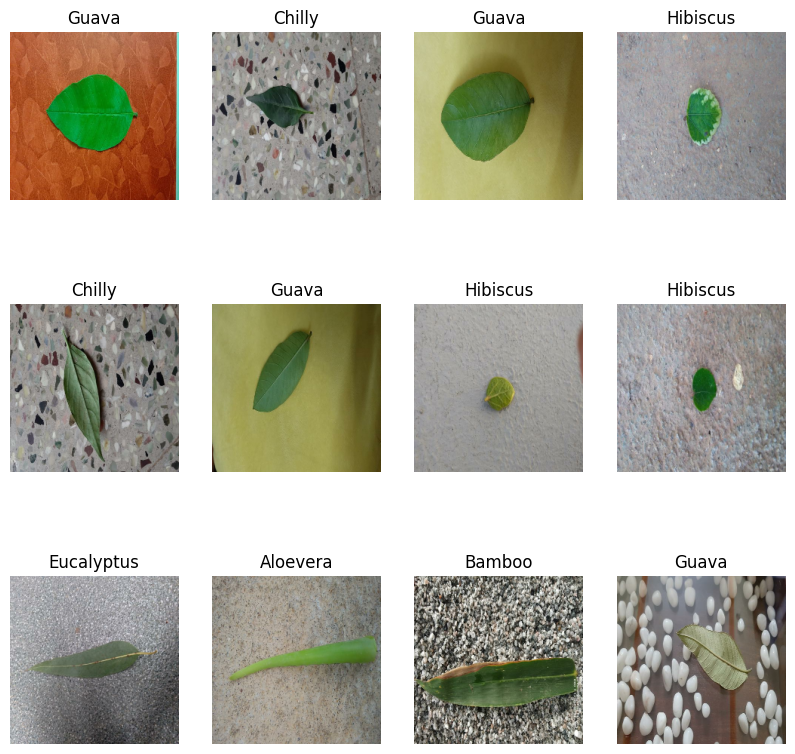

In [ ]:
# 3. Display some samples
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
#4. Train/Val/Test Split
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
#5. Improve performance with caching/prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# 6. Define Model using MobileNetV3
base_model = MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                              include_top=False,
                              weights='imagenet')
base_model.trainable = False  # freeze base model

model = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Lambda(preprocess_input),  # MobileNetV3 preprocessing
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# 7. Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# 8. Train the Model
EPOCHS = 50
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 599ms/step - accuracy: 0.3622 - loss: 1.8559 - val_accuracy: 0.9189 - val_loss: 0.5099
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.8691 - loss: 0.4878 - val_accuracy: 0.9189 - val_loss: 0.2224
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.9321 - loss: 0.2630 - val_accuracy: 0.9459 - val_loss: 0.1427
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.9745 - loss: 0.1406 - val_accuracy: 0.9730 - val_loss: 0.0827
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - accuracy: 0.9767 - loss: 0.0939 - val_accuracy: 0.9730 - val_loss: 0.0891
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.9900 - loss: 0.0712 - val_accuracy: 0.9730 - val_loss: 0.0526
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - accuracy: 0.9975 - loss: 0.0506 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 326ms/step - accuracy: 0.9955 - loss: 0.0419 - val_accuracy: 

In [ ]:
# 9. Evaluate on Test Data
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 1.0000 - loss: 0.0056
Test Loss: 0.003588852472603321
Test Accuracy: 1.0


In [ ]:
# 10. Plot Accuracy & Loss Graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

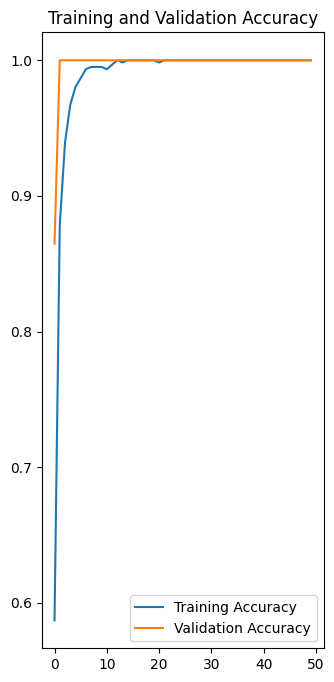

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

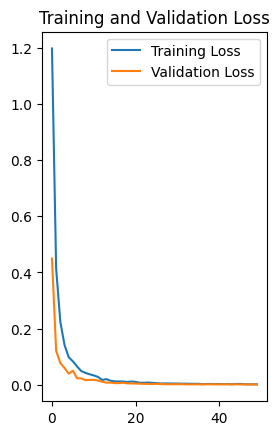

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual Label: Jackfruit
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: Jackfruit


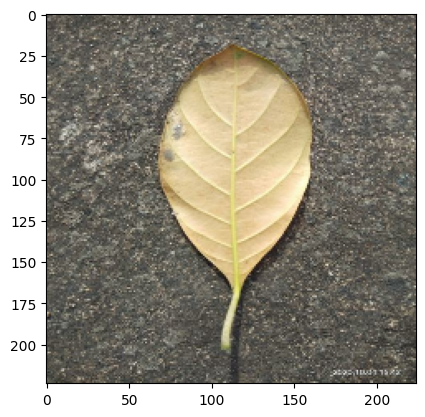

In [ ]:
#  11. Predict a Sample
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    plt.imshow(first_image)
    print("Actual Label:", class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
# 12. Define Predict Function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


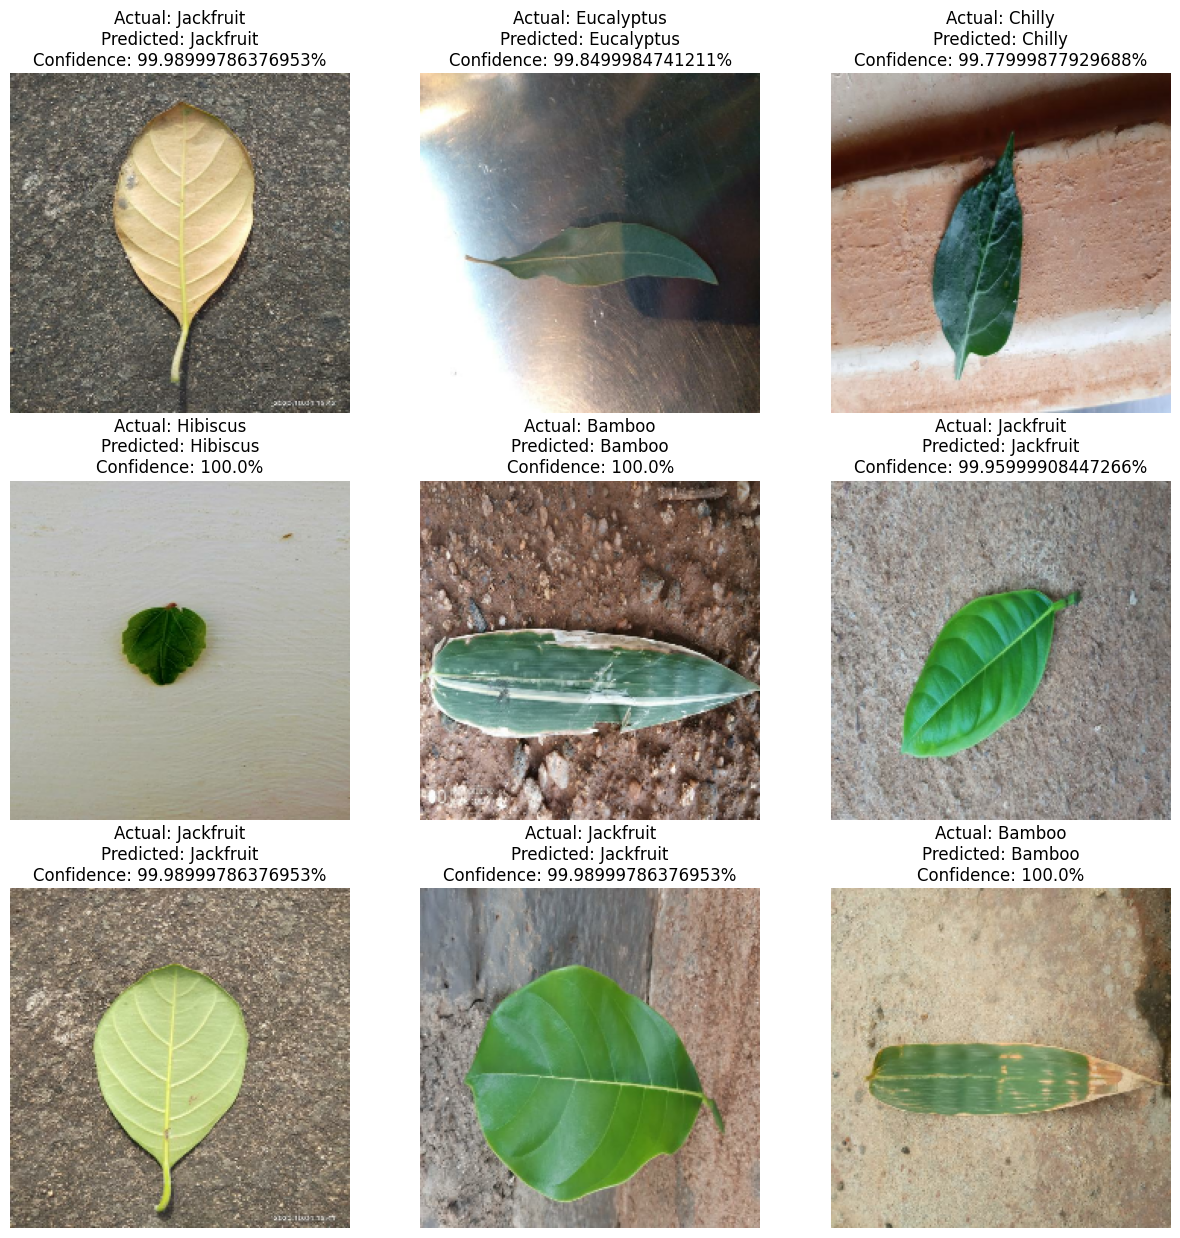

In [ ]:
#  13. Visualize Predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [ ]:
#  14. Save the Model
save_dir = "/content/drive/MyDrive/saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(f"{save_dir}/mobilenetv3_model.keras")